In [1]:
using JLD2
using FileIO
using PyPlot
using ColorSchemes
using PyCall
using StatsBase, Statistics
GS = pyimport("matplotlib.gridspec")
ticker = pyimport("matplotlib.ticker");
patches = pyimport("matplotlib.patches");

In [39]:
BI1 = load("/home/milan/analysis/bitinformation_50members_1-90.jld2","BI")
BI2 = load("/home/milan/analysis/bitinformation_50members_90-144.jld2","BI")
BI3 = load("/home/milan/analysis/bitinformation_50members_150-360.jld2","BI")

BI = vcat(BI1,BI2,BI3);

bitvec = collect(1:32)
timevec1 = collect(1:90) / 24       # in days, hourly
timevec2 = collect(93:3:144) / 24   # 3-hourly
timevec3 = collect(150:6:360) / 24; # 6-hourly
timevec = vcat(timevec1,timevec2,timevec3);

BInan = copy(BI)
BInan[iszero.(BI)] .= NaN;

In [3]:
size(BI)

(144, 32)

In [4]:
Xzstd1,Xzfp1 = load("/home/milan/analysis/ensemble_compression_1-90.jld2","Xzstd","Xzfp")
Xzstd2,Xzfp2 = load("/home/milan/analysis/ensemble_compression_90-144.jld2","Xzstd","Xzfp")
Xzstd3,Xzfp3 = load("/home/milan/analysis/ensemble_compression_150-360.jld2","Xzstd","Xzfp")

Xzstd = vcat(Xzstd1,Xzstd2,Xzstd3)
Xzfp = vcat(Xzfp1,Xzfp2,Xzfp3)

size(Xzstd)

(144,)

In [40]:
# via preserving p amount of information
p = 0.98
ntsteps = size(BI)[1]
bits_with_information = [argmax(cumsum(BI[t,:]) .> p*sum(BI[t,:])) for t in 1:ntsteps];

In [79]:
# via insignificantly different from 0
# pmax = maximum(BI[:,22:end])
# argmin(diff(BI .> pmax,dims=2),dims=2)
# bits_with_information = [argmin(diff(BI[t,:] .> pmax)) for t in 1:ntsteps];

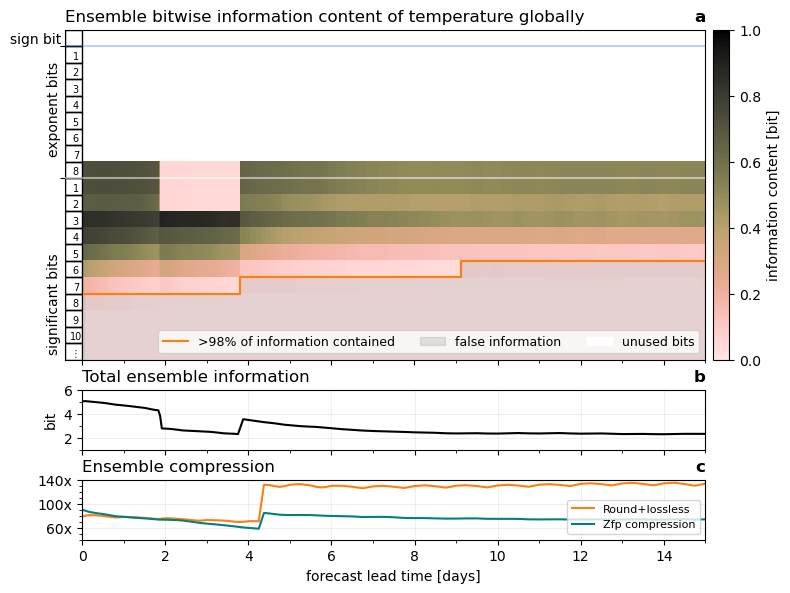

In [41]:
## plotting
fig = figure(figsize=(8,6))

ax1 = fig.add_axes([0.1,0.4,.8,.55])
shortx0 = 0.021
ax2 = fig.add_axes([0.1+shortx0,0.25,.8-shortx0,.1])
ax3 = fig.add_axes([0.1+shortx0,0.1,.8-shortx0,.1])

pos = ax1.get_position()
cax = fig.add_axes([pos.x1+0.01,pos.y0,0.02,pos.y1-pos.y0])
ax1.invert_yaxis()

# information
cmap = ColorMap(ColorSchemes.turku.colors).reversed()
cmap_array = cmap(0:1/100000:1)
cmap_array[1,:] = [1,1,1,1]

pcm = ax1.pcolormesh(timevec,bitvec,BInan',vmin=0,vmax=1,shading="nearest";cmap)
cbar = colorbar(pcm,cax=cax,orientation="vertical")
cbar.set_label("information content [bit]")

ax1.axhline(1.5,alpha=.3,lw=1.5,zorder=10)
ax1.axhline(9.5,alpha=.5,lw=1.5,color="w",zorder=10)

# total information
ax2.plot(timevec,sum(BI,dims=2),"k")
ax1.fill_between(timevec,32*ones(length(timevec)),0.5 .+ bits_with_information,
                color="grey",alpha=0.2,step="mid",label="false information")
ax1.plot(timevec,0.5 .+ bits_with_information,"C1",ds="steps-mid",label=">98% of information contained")


# only for legend
ax1.fill_between([0,0],[0,0],color="w",label="unused bits")

# show bits
ax1.add_patch(patches.Rectangle((-.4,.5),.4,1,edgecolor="k",fill=false))
for y in bitvec[2:20]
    ax1.add_patch(patches.Rectangle((-.4,y-.5),.4,1,edgecolor="k",fill=false))
    
    if y < 10
        bit_string = string(y-1)
    elseif y < 20
        bit_string = string(y-9)
    else
        bit_string = "⋮"
    end
    
    ax1.text(-.15,y+.1,bit_string,fontsize=7,ha="center",va="center")
end

# compression factors
ax3.plot(timevec,Xzstd,"C1",label="Round+lossless")
ax3.plot(timevec,Xzfp,"teal",label="Zfp compression")

ax1.set_title("Ensemble bitwise information content of temperature globally",loc="left")
ax2.set_title("Total ensemble information",loc="left")
ax3.set_title("Ensemble compression",loc="left")

ax1.set_title("a",loc="right",fontweight="bold")
ax2.set_title("b",loc="right",fontweight="bold")
ax3.set_title("c",loc="right",fontweight="bold")
ax1.legend(loc=4,ncol=3,fontsize=9)
ax3.legend(loc=4,ncol=1,fontsize=8)

ax1.set_xlim(-.4,360/24)
ax2.set_xlim(0,360/24)
ax3.set_xlim(0,360/24)

ax1.set_ylim(20.5,0.5)
ax2.set_ylim(1,6)
ax3.set_ylim(40,140)

ax1.set_yticks([1.5,9.5])
ax2.set_yticks(2:2:6)
ax2.set_yticks(1:6,minor=true)
ax3.set_yticks([60,100,140])
ax3.set_yticks(40:10:140,minor=true)
ax2.set_ylabel("bit")
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax1.set_xticks(1:15,minor=true)
ax2.set_xticks(1:15,minor=true)
ax3.set_xticks(1:15,minor=true)
ax3.set_xlabel("forecast lead time [days]")

ax2.grid(alpha=.2)
ax3.grid(alpha=.2)

ax3.yaxis.set_major_formatter(ticker.FormatStrFormatter("%dx"))

ax1.text(-0.5,1.3,"sign bit",ha="right")
ax1.text(-0.5,8,"exponent bits",rotation=90,ha="right")
ax1.text(-0.5,20,"significant bits",rotation=90,ha="right")
savefig("../plots/ensemble_information.png")